# Model Assessment and Selection

The generalization performance of a learning method relates to its prediction capability on independent test data

## Bias, Variance and Model Complexity

The case of a quantitative response
* target variable $Y$ ,
* a vector of inputs $X$, and a
* prediction model $\hat{f}(X)$ that has been estimated from a training set $T$

The loss function for measuring errors between $Y$ and $\hat{f}(X)$ is denoted by $L(Y, \hat{f}(X))$

A typical choice is squared error.

$$L(Y, \hat{f}(X))=(Y - \hat{f}(X))^2$$

**Test error** (generalization error) is the prediction error over an independent test sample. Sample out of $T$.

$$Err_T = E[L(Y, \hat{f}(X))|T]$$

* Where both X and Y are drawn randomly from their joint distribution. 
* The training set $T$ is fixed, and test error refers to the error for this specific training set, but recall, it is evalued for sample out of $T$.

* A related quantity is the expected prediction error (or expected test error).

$$Err = E[L(Y, \hat{f}(X))] = E[Err_T]$$

* We focus on $Err_T$

**Training error** is the average loss over the training sample

$$\bar{\text{err}} = \frac{1}{N} \sum_{i=1}^{N} L(y_i, \hat{f}(x_i))$$

* As the model becomes more and more complex, it uses the training data more and is able to adapt to more complicated underlying structures. 

* Hence there is a decrease in bias but an increase in variance. 

* Training error consistently decreases with model complexity, typically dropping to zero if we increase the model complexity enough. 

* However, a model with zero training error is overfit to the training data and will typically generalize poorly

<div align = "center">
  <img src = "assets/assessment/Captura_mcomplex.PNG" />  
</div>

Behavior of test sample and training sample error as the model complexity is varied

* Light blue curves show the *training error*
    * Solid blue curve is the average.
* Light red curves show the *test error* condicionated (previosly trained) on $T$, so this is $\text{Err}_T$
    * Solid red curve is the average. This is $E[\text{Err}_T]$

In [1]:
from scipy.stats import uniform
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection, metrics
from sklearn.neighbors import KNeighborsRegressor

In [2]:
size_population = 1_000_0000
X = np.linspace(0,6, size_population)
f = np.sin(X)
y = f + np.random.randn(size_population)
data_population = pd.DataFrame({'X':X, 'y':y})

In [3]:
np.random.seed(123)
random_states = np.random.randint(1000, 5000, 70)

In [4]:
from collections import namedtuple

mse_model = namedtuple('mse_model', ['mse_train', 'mse_test', 'n_neighbors'])

In [109]:
model_eval_to_frame = []

for random_state in random_states:

    for n_neighbors in range(1, 21):

        sample = data_population.sample(50, random_state=random_state, replace=False)
        X, y = sample[['X']], sample.y
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=random_state)
        kneigbors = KNeighborsRegressor(n_neighbors=n_neighbors)
        kneigbors.fit(X_train, y_train)
        mse_train = metrics.mean_squared_error(y_true=y_train, y_pred=kneigbors.predict(X_train))
        mse_test = metrics.mean_squared_error(y_true=y_test, y_pred=kneigbors.predict(X_test))
        mse_model_realized = mse_model(mse_test=mse_test, mse_train=mse_train, n_neighbors=n_neighbors)
        model_eval_to_frame.append(mse_model_realized)

In [139]:
model_eval = pd.DataFrame(model_eval_to_frame)
model_eval['idx'] = model_eval.groupby('n_neighbors').cumcount()
model_eval_pivot = model_eval.pivot(index = 'idx', columns= 'n_neighbors')

model_eval_pivot_tab = model_eval_pivot.stack(1).unstack(0)
model_eval_pivot_tab['complex'] = range(20, 0, -1)
model_eval_pivot_tab.set_index('complex', inplace=True)
model_eval_pivot_tab.sort_index(axis=0, inplace=True)

Text(17.5, 4.5, 'Low  bias')

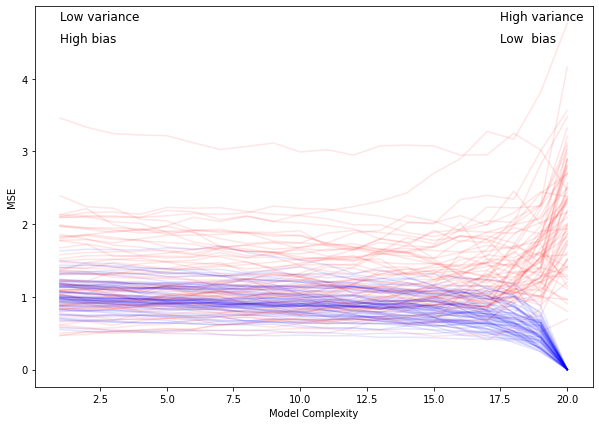

In [159]:
fig, ax = plt.subplots(figsize = (10, 7) )
for mse_name in ['mse_test', 'mse_train']:
    color = 'r' if mse_name == 'mse_test' else 'b'
    model_eval_pivot_tab[mse_name].plot(ax =ax, color = color, alpha = 0.1, legend = False)

ax.set(xlabel = 'Model Complexity', ylabel = 'MSE')


ax.text(1, 4.8, 'Low variance', fontsize = 12)
ax.text(1, 4.5, 'High bias', fontsize = 12)
ax.text(17.5, 4.8, 'High variance', fontsize = 12)
ax.text(17.5, 4.5, 'Low  bias', fontsize = 12)

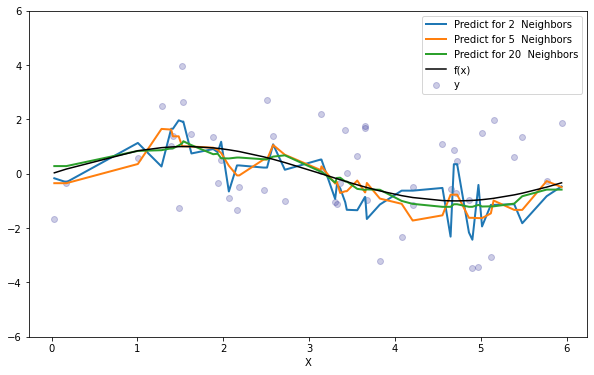

In [51]:
fig, ax = plt.subplots(figsize = (10, 6))

for n_neighbors in [2, 5, 20]:
        sample = data_population.sample(200, random_state=123 ,replace=False)
        X, y = sample[['X']], sample.y
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=123)
        kneigbors = KNeighborsRegressor(n_neighbors=n_neighbors)
        kneigbors.fit(X_train, y_train)
        X_test_sorted = (X_test.sort_values('X')).values
        X_test_sorted_flat = X_test_sorted.flatten()
        ax.plot(X_test_sorted_flat, kneigbors.predict(X_test_sorted), label = rf'Predict for {n_neighbors}  Neighbors', lw = 2)

ax.plot(X_test_sorted_flat, np.sin(X_test_sorted_flat), color = 'k', label = r'f(x)')
ax.scatter(X_test_sorted_flat, y_test, color = (0, 0, 0.5), alpha=0.2, label = 'y')
ax.set_ylim(-6, 6)
ax.set(xlabel = 'X')
ax.legend()

As we can see, the variance of the predictions for k = 2 is greater than the variance for prections for k = 20

The similar results can be found in categorical models. 

* The response $G$ taking one of $K$ values in a set $g$, labeled for convenience as $1, 2, . . . , K$. 

* Typically we model the probabilities $p_{k(X)} = Pr(G = k|X)$, and then $\hat{G}(X) = \argmax_{k} \hat{p}_{k(X)}$.

* Typical loss functions are

  * $L(G, \hat{G}(X)) = I(G \neq \hat{G}(X)) - (0–1 \;\text{loss})$
  
  * $L(G, \hat{p}(X)) = -2 log \; \hat{p}_G (X) - (−2 × log-likelihood)$

* Test error here is $\text{Err}_\text{T} = E[L(G, \hat{G}(X))|T ]$ the population misclassification error of the classifier trained on $T$.

* Trainning error using −2 × log-likelihood is $\bar{\text{err}} = -\frac{2}{N}\sum_{1}^{N} log \hat{p}_{g_i}(x_i)$


We describe a number of methods for estimating the **expected test error** for a model.

Typically our model will have a tuning parameter or parameters $α$ and so we can write our predictions as $\hat{f}_{\alpha}(x)$. 

The tuning parameter varies the complexity of our model, and we wish to find the value of α that minimizes error.

* We have two goals:

  * *Model selection*: estimating the performance of different models in order to choose the best one

  * *Model assessment*: having chosen a final model, estimating its prediction error (generalization error) on new data.


* The best approach is randomly divide the dataset into three parts:
  * Training set (It's used for *model selection*) $50\%$
  * Validation set (It's used for *model selection*) $25\%$
  * Test set (It's used for *model assessment*) $25\%$. The test set should be kept in a “vault,” and be brought out only
at the end of the data analysis
   






## The Bias–Variance Decomposition

* Given $Y = f(X) + \epsilon$, where $E[\epsilon] = 0$ and $V[\epsilon] = \sigma_{\epsilon}^2$

* The expected prediction error of a regression fit $\hat{f}(X)$ at an input point $X = x_0$ is 

$$E[(Y - \hat{f}(x_0))^2 |X = x_0]$$

$$E[(f(X) + \epsilon - \hat{f}(x_0))^2 |X = x_0]= E[(f(x_0) + \epsilon - \hat{f}(x_0))^2]$$

$$E[f(x_0)^2 + \epsilon^2 + 2\epsilon f(x_0) +  \hat{f}(x_0)^2 - 2 (f(x_0) + \epsilon)\hat{f}(x_0)]= \sigma_{\epsilon}^2 + E[(f(x_0) - \hat{f}(x_0))^2]$$

$$ \sigma_{\epsilon}^2 + E[f(x_0)^2 + \hat{f}(x_0)^2 - 2 f(x_0)\hat{f}(x_0) ] = \sigma_{\epsilon}^2 +  E[f(x_0)^2 + E[\hat{f}(x_0)]^2 - E[\hat{f}(x_0)]^2+ \hat{f}(x_0)^2 - 2 f(x_0)\hat{f}(x_0) ] $$

$$= \sigma_{\epsilon}^2+  E[f(x_0)^2] + E[\hat{f}(x_0)]^2 - E[\hat{f}(x_0)]^2+ E[\hat{f}(x_0)^2] - 2 E[f(x_0)\hat{f}(x_0) ] $$

$$= \sigma_{\epsilon}^2 + (E[\hat{f}(x_0)^2] - E[\hat{f}(x_0)]^2) +  (f(x_0)^2 + E[\hat{f}(x_0)]^2  - 2 f(x_0) E[\hat{f}(x_0) ] ) $$

$$ = \sigma_{\epsilon}^2 + E[(\hat{f}(x_0) -  E[\hat{f}(x_0)])^2] + [E[\hat{f}(x_0)] - f(x_0)]^2$$

$$ = \text{irreductible error} + \text{Var}(\hat{f}(x_0)) + \text{bias}^2$$



* The first term is the variance of the target around its true mean $f(x_0)$, and cannot be avoided no matter how well we estimate $f(x_0)$

* The second term is variance, the expected squared deviation of $\hat{f}(x_0)$ around its mean.

* The third term is bias, the amount by which the average of our estimate differs from the true mean.
* Typically the more complex we make the model $\hat{f}$, the lower the (squared) bias but the higher the variance.

* For the $k$-nearest-neighbor regression fit

$$E[(Y - \hat{f}(x_0))^2 |X = x_0]$$

$$ = \sigma_{\epsilon}^2  +  [ f(x_0)  - \frac{1}{k} \sum_{l=1}^{k} f(x_l)] + \frac{\sigma_{\epsilon}^2}{k}$$

* Here we assume for simplicity that training inputs $x_i$

* The number of neighbors $k$ is inversely related to the model complexity. For small $k$, the estimate $\hat{f}_k(x)$ can potentially adapt itself better to the underlying $f(x)$. 

* As we increase $k$, the bias—the squared difference between $f(x_0)$ and the average of $\hat{f}(x_0)$ at the $k$-nearest neighbors—will typically increase, while the variance decreases.

### Bias–Variance Tradeoff - Example

In [255]:
from collections import namedtuple

mse_model = namedtuple('mse_model', ['mse_test','Var', 'bias' ,'n_neighbors'])

In [259]:
model_eval_to_frame = []

for random_state in random_states:

    for n_neighbors in range(1, 20):
        
        sample = data_population.sample(50, random_state=random_state, replace=False)
        X, y = sample[['X']].values, sample.y.values
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=random_state)
    
        # Model
        kneigbors = KNeighborsRegressor(n_neighbors=n_neighbors)
        kneigbors.fit(X_train, y_train)

        mse_test = metrics.mean_squared_error(y_true=y_test, y_pred=kneigbors.predict(X_test))
        
        mse_model_realized = mse_model(
            mse_test=mse_test, 
            n_neighbors=n_neighbors, 
            Var=np.var(kneigbors.predict(X_test)), 
            bias=mse_test - np.var(kneigbors.predict(X_test)) )
        
        model_eval_to_frame.append(mse_model_realized)

In [289]:
model_eval = pd.DataFrame(model_eval_to_frame)
model_eval['idx'] = model_eval.groupby('n_neighbors').cumcount()
model_eval_pivot = model_eval.pivot(index = 'idx', columns= 'n_neighbors')
model_eval_pivot_tab = model_eval_pivot.stack(1).unstack(0)

model_eval_pivot_tab = model_eval_pivot_tab.sort_index(axis=0, ascending=False).copy()
model_eval_pivot_tab.index = model_eval_pivot_tab.index.astype(str)

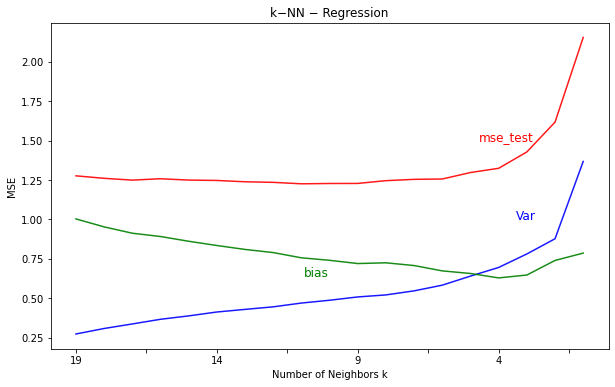

In [327]:
fig, ax = plt.subplots(figsize = (10, 6) )

colors = ['r', 'b', 'g']
var_bias =['mse_test', 'Var', 'bias']

for color, mse_name in zip(colors, var_bias):
    to_plot = model_eval_pivot_tab[mse_name].mean(axis=1)
    to_plot.name = mse_name
    to_plot.plot(ax =ax, color = color, alpha = 0.9, legend = False)

ax.set(xlabel = 'Number of Neighbors k', ylabel = 'MSE', title = 'k−NN − Regression')

ubis = [(14.3, 1.5), (15.6, 1), (8.1, 0.64)]

for color, mse_name, ubi in zip(colors, var_bias, ubis):
    ax.text(*ubi, mse_name, fontsize = 12, color = color)


## The Bayesian Approach and BIC

## Cross-Validation

* This method directly estimates the expected extra-sample error $Err = E[L(Y, \hat{f}(X))]$
* The average generalization error when the method $\hat{f}(X)$ is applied to an independent test sample from the joint distribution of $X$ and $Y$.

#### K-Fold Cross-Validation

* $K$-fold crossvalidation uses part of the available data to fit the model, and a different part to test it.
* We split the data into $K$ roughly equal-sized parts, for example, when $K = 5$, the scenario looks like this

<center>

|1|2|3|4|5|
|-|-|-|-|-|
|train|train|validation|train|train|

</center>

* For the $k_{th}$ part (third above), we fit the model to the other $K − 1$ parts of the data, and calculate the prediction error of the fitted model when predicting the kth part of the data. 

The cross-validation estimate of prediction error is:

$$CV(\hat{f}) = \frac{1}{N} \sum_{i=1}^{N} L(y_i, \hat{f}^{−κ(i)}(x_i))$$

* For $K = 5$, the $5^{th}$ part of the training data is of size N, where the points is randomly localized.
* The 4 parts remaining is used to fit.
* Denote by $\hat{f}^{−k(x)}$ the fitted function

Given a set of models $f(x, α)$ indexed by a tuning parameter $α$, denote by $\hat{f}^{−k(i)}{(x_i, α)}$ the $α$ th model fit with the $k$ th part of the data removed. Then for this set of models we define.

$$CV(\hat{f}, \alpha) = \frac{1}{N} \sum_{i=1}^{N} L(y_i, \hat{f}^{−κ(i)}(x_i, \alpha_i))$$

The function $CV(\hat{f}, α)$ provides an estimate of the test error curve, and we find the tuning parameter $\hat{α}$ that minimizes it

* $K=5$ is chosen if the size of data training is enought big.  
* Overall, five- or tenfold cross-validation are recommended as a good compromise: see Breiman and Spector (1992) and Kohavi (1995).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from sklearn import model_selection, metrics
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Load the data
data_drime = pd.read_stata(r'data_dta/CRIME1.dta')

# Generate the variable arr86, where a person is labeled equal to 0, if he has not committed a crime in 1986
# otherwise 1.
data_drime['arr86'] = data_drime.narr86.where(data_drime.narr86==0, 1)

# Selecting the features and target
features= ['pcnv', 'avgsen', 'tottime', 'ptime86', 'qemp86']
target = 'arr86'

X = np.array(data_drime[features])
y = np.array(data_drime[target])

# Split the data to train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=123, test_size=0.25)

The simplest way to use cross-validation is to call the `cross_val_score` 

In [80]:
fit_to_grid_cv = model_selection.GridSearchCV(
    
    estimator=RandomForestClassifier(
        n_estimators=200),
    scoring= 'roc_auc',
    cv=5,
    param_grid={
        'ccp_alpha': np.exp(np.linspace(-10,10, 10)), \
        'min_samples_split':range(2, 10)},
    verbose=False,
    return_train_score=True
)

In [81]:
fit_to_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=200),
             param_grid={'ccp_alpha': array([4.53999298e-05, 4.18942123e-04, 3.86592014e-03, 3.56739933e-02,
       3.29192988e-01, 3.03773178e+00, 2.80316249e+01, 2.58670631e+02,
       2.38696456e+03, 2.20264658e+04]),
                         'min_samples_split': range(2, 10)},
             return_train_score=True, scoring='roc_auc', verbose=False)

In [82]:
fit_to_grid_cv.best_params_

{'ccp_alpha': 0.0038659201394728076, 'min_samples_split': 3}

In [88]:
random_model_class = RandomForestClassifier(n_estimators=200, **fit_to_grid_cv.best_params_)
random_model_class.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.0038659201394728076, min_samples_split=3,
                       n_estimators=200)

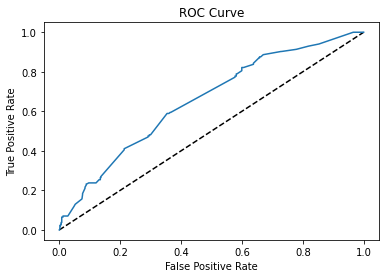

In [93]:
def plot_roc(mod, X, y):
    # predicted_probs is an N x 2 array, where N is number of observations
    # and 2 is number of classes
    predicted_probs = mod.predict_proba(X_test)

    # keep the second column, for label=1
    predicted_prob1 = predicted_probs[:, 1]

    fpr, tpr, _ = metrics.roc_curve(y_test, predicted_prob1)

    # Plot ROC curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")

plot_roc(random_model_class, X_test, y_test)

In [95]:
predicted_prob1 = random_model_class.predict_proba(X_test)[:, 1]
auc = metrics.roc_auc_score(y_test, predicted_prob1)
print(f"Initial AUC value is {auc:.4f}")

Initial AUC value is 0.6541


In [101]:
accu = metrics.accuracy_score(y_test, random_model_class.predict(X_test))
print(f'The accuracy {accu:.4f}')

recall = metrics.recall_score(y_test, random_model_class.predict(X_test))
print(f'The recall {recall:.4f}')

prec = metrics.precision_score(y_test, random_model_class.predict(X_test))
print(f'The precision {accu:.4f}')

The accuracy 0.7346
The recall 0.0432
The precision 0.7346


In [ ]:
# If we want to create ourselves scoring
# Definite a function score

def scoring_funct(y_true, y_predict):
    return -(np.absolute(y_true - y_predict)).mean()

# Passing for make score. This scorer can be included in scoring (in GridSearchCV)
scorer = metrics.make_scorer(score_func=scoring_funct, greater_is_better=True)

##  Bootstrap Methods

### Bootstrap Methods

* The bootstrap is a general tool for assessing statistical accuracy. 

* Suppose we have a model fit to a set of training data. We denote the training set by $Z = (z_1, z_2, ..., z_N )$ where $z_i = (x_i, y_i)$. 

* The basic idea is to randomly draw datasets with replacement from the training data, each sample the same size as the original training set. This is done $B$ times producing $B$ bootstrap datasets.

* Let $\~{Z}^{b}$ the $b^{\text{th}}$ sample bootstraping

* We can estimate any aspect of the distribution of $S(\~{Z}^{b})$, where $S$ is a point estimation of some parameter

$$\text{Var}[S(\~{Z}^{b})] = \frac{1}{B-1} \sum_{b=1}^{B} (S(\~{Z}^{b}) - \bar{S})^2$$

* Where $\bar{S} = \sum_{b} S(\~{Z}^{b}) /B$ 

* Then we refit the model to each of the bootstrap datasets, and examine the behavior of the fits over the $B$ replications.

* If $f^{*b}(x_i)$ is the predicted value at $x_i$, from the model fitted to the $b^{\text{th}}$ bootstrap dataset, our estimate is
$$\text{Err}_{\text{boot}} = \frac{1}{B}\;\frac{1}{N}\sum_{b=1}^{B} \sum_{i = 1}^{N} L(y_i, f^{*b}(x_i))$$
But $\text{Err}_{\text{boot}}$ does not provide a good estimate in general. 

* The reason is that the bootstrap datasets are acting as the training samples, while the original training set is acting as the test sample, and these two samples have observations in common. 

* This overlap can make overfit predictions look unrealistically good
A better bootstrap estimate can be obtained. For each observation, we only keep track of predictions from bootstrap samples not containing that observation. The leave-one-out bootstrap estimate of prediction error is defined by
$$Err_{boot} = \frac{1}{N}\;\sum_{i=1}^{N} \frac{1}{|C^{-i}|} \sum_{b \in C^{-i}}^{B} L(y_i, f^{*b}(x_i)$$
